## Visión por Computadora - Trabajo Práctico 3

### Integrantes
- Eduardo Echeverría
- Diego Braga

### Enunciado

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template.

1. Obtener una detección del logo en cada imagen sin falsos positivos
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

In [8]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

In [9]:
# Ruta a las imágenes y al template
image_paths = glob.glob('./images/*.*')
template_path = './template/pattern.png'

### 1. Obtener una detección del logo en cada imagen sin falsos positivos

Para resolver este ejercicio se presentaron varias dificultades antes de llegar al resultado final:

1. El primer punto que se notó previo a realizar los experimentos es que los logos a detectar tienen diferentes resoluciones. Esto implicará realizar evaluaciones para diferentes escalas del template original.

2. Se realizaron varias pruebas obteniendo los bordes de las imágenes originales y del template con Canny y luego se evaluaron las métricas. Se obtuvieron buenos resultados para la métrica TM_CCORR_NORMED (correlación normalizado) pero sólo con templates realativamente grandes, lo cual no es aceptable ya que por ejemplo la imagen *coca_multi.png* presenta logos en menor resolución. Al ser dimensiones tan pequeñas, los bordes quedan muy imprecisos y resulta en falsos positivos sobre diferentes artefectos de la imagen (ej. bordes). Otro caso particular es el de la imagen *COCA-COLA-LOGO.jpg* que incluye un sombreado en las letras que requiere una configuración especial del algoritmo (Canny) que no funciona correctamente para todas las imágenes. Los mejores resultados se dieron aplicando Canny previo al escalado, dado que cv.resize aplica interpolación que mejora notoriamente las detecciones. En resumen, la utilización de Canny es viable si se utilizan o bien diferentes parametrizaciones de Canny, o diferentes métricas de evaluación dependiendo de alguna heurística que distinga cada situación de forma genérica. No fue el camino elegido dado que es muy difícil generalizarlo para futuras imágenes.

3. Los logos presentes en botellas o latas tienen la particularidad son curvadas y por lo general ninguna de las métricas daba buenos resultados en este tipo de imágenes. Se decidió que la mejor forma de evitar estos problemas es tomar sólo un porcentaje central con respecto al ancho del template (ej. 70%). Este criterio no afectaría tanto a la detección ya que captura elementos esenciales del logotipo. Se podrían haber tomado más áreas del logo para lograr más detecciones (ej. sector izquierdo o derecho), pero no se hizo para optimizar el procesado.

4. En algunos casos el logo aparece con letras oscuras sobre fondo claro, y en otros sucede lo contrario. Por lo tanto, se decidió utilizar dos variaciones del template para cada medida, una con la versión binarizada (blanco y negro) y otra con el negativo. O sea, letras negras con fondo blanco, o letras blancas con fondo negro. A pesar de que las imágenes probablemente no presenten estas intensidades extremas, es suficiente para que el algoritmo realiza la detección adecuadamente y de la forma más genérica posible para éste y tal vez otros logos del mismo estilo.

La métrica utilizada fue TM_CCOEFF_NORMED (coeficiente de correlación normalizado) debido a que fue la que mejores resultados arrojó. Esto se debe a que el calculo normaliza las intensidades tanto del template como de la imagen, evitando así los problemas que tiene TM_CCORR_NORMED con los falsos positivos (ej. en áreas blancas cuando el template tiene fondo blanco blanco o viceversa). En el caso de TM_SQDIFF_NORMED también hubo problemas de falsos positivos dadas la binarización de los templates que provocaban detecciones en áreas totalmente blancas o negras.

A continuación se presentan las funciones necesarias para la resolución del problema y también su ejecución sobre las imágenes de ejemplo.

In [10]:
def process_template(template_gray):
    """
    Realiza el procesamiento del template para este ejercicio en particular.

    Args:
        template_gray (numpy.ndarray): Imagen en escala de grises del template.
    Returns:
        list: Lista con el resultado del procesamiento del template.
    """
    processed_templates = []

    # Se recorta la imagen de forma de quedarse con el 70% central de la misma (respecto al ancho)
    new_width = int(template_gray.shape[1] * 0.70)
    start_x = (template_gray.shape[1] - new_width) // 2
    template_gray = template_gray[:, start_x:start_x + new_width]

    # Se binariza la imagen con un threshold adecuado de forma que diferencie correctamente los colores de las letras y el fondo
    _, template_gray = cv.threshold(template_gray, 150, 255, cv.THRESH_BINARY)

    processed_templates.append(template_gray)

    # Se calcula el negativo de la imagen y también se lo devuelve
    template2 = 255 - template_gray
    processed_templates.append(template2)

    return processed_templates

In [11]:
def match_logo(img, processed_templates, template_aspect_ratio, min_scale=0.25, max_scale=3):
    """
    Realiza la detección del logotipo en la imagen utilizando los templates procesados.

    Args:
        img (numpy.ndarray): Imagen a procesar.
        processed_templates (list): Lista de templates procesados.
        template_aspect_ratio (float): Proporción de aspecto del template.
        min_scale (float, opcional): Valor mínimo de escala para la búsqueda.
        max_scale (float, opcional): Valor máximo de escala para la búsqueda.
    Returns:
        numpy.ndarray: Imagen con las detecciones realizadas.
        float: Valor de la métrica de coincidencia.
        numpy.ndarray: Imagen resultado de la métrica
        float: Escala utilizada.
    """
    # Se trabajará con la imagen en escala de grises
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    img_h, img_w = img_gray.shape
    best_match = None
    best_val = -1
    best_loc = None
    best_scale = None
    best_res = None

    # Se crea espacio lineal de escalas
    scales = np.linspace(min_scale, max_scale, 100)

    for scale in scales:

        for template_item in processed_templates:

            # Se utiliza la función cv.resize para utilizar escala arbitraria
            scaled_template = cv.resize(template_item, None, fx=scale, fy=scale)
            scaled_template_h, scaled_template_w = scaled_template.shape

            # Se chequea que el template escalado no supere el tamaño de la imagen (en ancho o en alto)
            if scaled_template_h <= img_h and scaled_template_w <= img_w:

                # Se ejecuta el algoritmo de template matching con la métrica Coeficiente de correlación normalizado
                res = cv.matchTemplate(img_gray, scaled_template, cv.TM_CCOEFF_NORMED)

                min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

                # Se actualiza el mejor valor
                if max_val > best_val:
                    best_val = max_val
                    best_loc = max_loc
                    best_match = scaled_template
                    best_scale = scale
                    best_res = res

    # Se dibuja el rectángulo en la imagen, considerando que hay que utilizar la relación de aspecto del template original
    best_w, best_h = best_match.shape[::-1]
    best_w_full = int(best_h * template_aspect_ratio)
    w_padding = int((best_w_full - best_w) / 2)
    top_left = best_loc
    top_left = (top_left[0] - w_padding, top_left[1])
    bottom_right = (min(top_left[0] + best_w_full, img.shape[1]), top_left[1] + best_h)
    top_left = (max(0, top_left[0]), top_left[1])
    cv.rectangle(img, top_left, bottom_right, (0, 255, 0), 3)

    return img, best_val, best_res, best_scale

In [12]:
def match_logo_in_images(image_paths, template_path):
    """
    Realiza la detección del logotipo en las imágenes dadas.
    Despliega los resultados en pantalla.

    Args:
        image_paths (list): Lista de rutas a las imágenes a procesar.
        template (numpy.ndarray): Imagen del template.
    """

    template = cv.imread(template_path, 0)

    # Se procesa el template (generando otros templates a utilizar en el algoritmo de template matching)
    processed_templates = process_template(template)
    template_aspect_ratio = template.shape[1] / template.shape[0]

    # Se muestran los templates generados
    template_idx = 1
    for template_item in processed_templates:
        plt.figure()
        plt.imshow(cv.cvtColor(template_item, cv.COLOR_BGR2RGB))
        plt.title(f'Template generado ({template_idx})')
        plt.show()
        template_idx += 1

    # Se procesan las imágenes de ejemplo
    for image_path in image_paths:

        img = cv.imread(image_path)
        detected_img, metric, best_res, best_scale = match_logo(img, processed_templates, template_aspect_ratio)

        # Se muestra el resultado de la métrica y las detecciones sobre la imagen original
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(best_res, cmap='gray')
        axes[0].set_title('Mejor resultado TM_CCOEFF_NORMED')
        axes[1].imshow(cv.cvtColor(detected_img, cv.COLOR_BGR2RGB))
        axes[1].set_title(f'Métrica: {metric:.2f}, escala: {best_scale}')
        plt.tight_layout()
        plt.show()

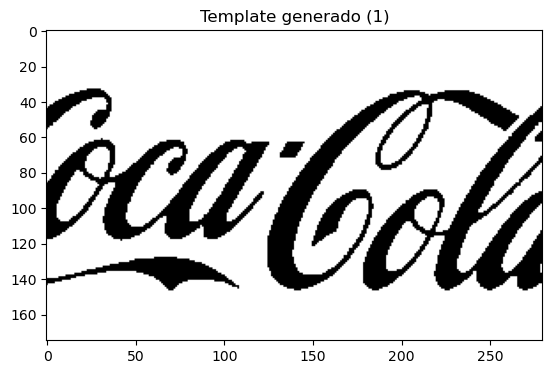

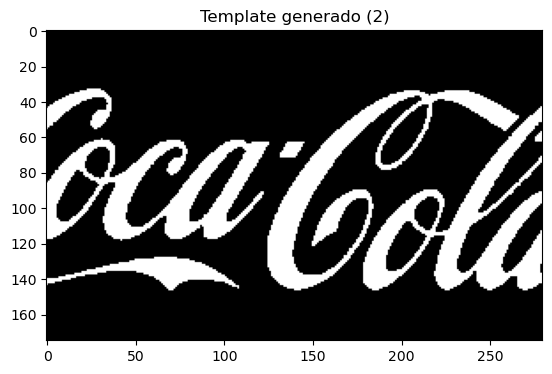

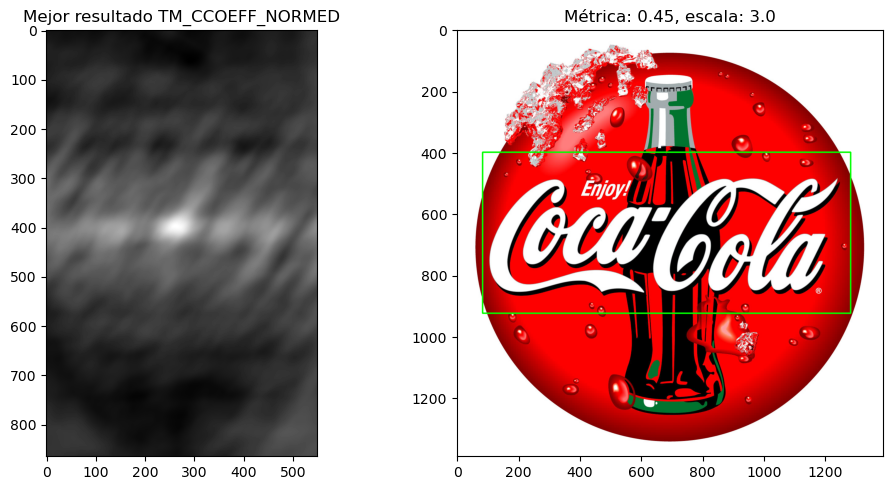

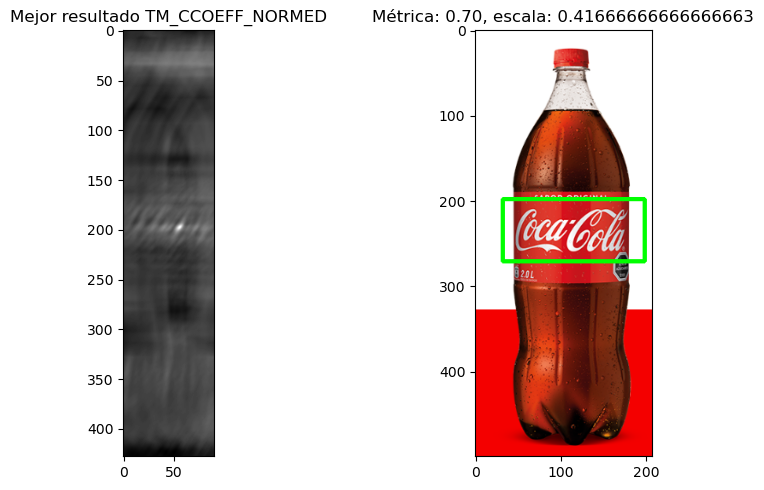

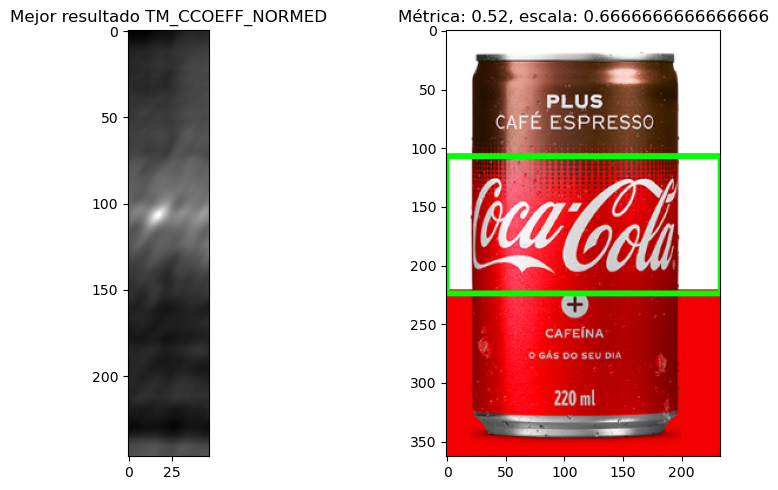

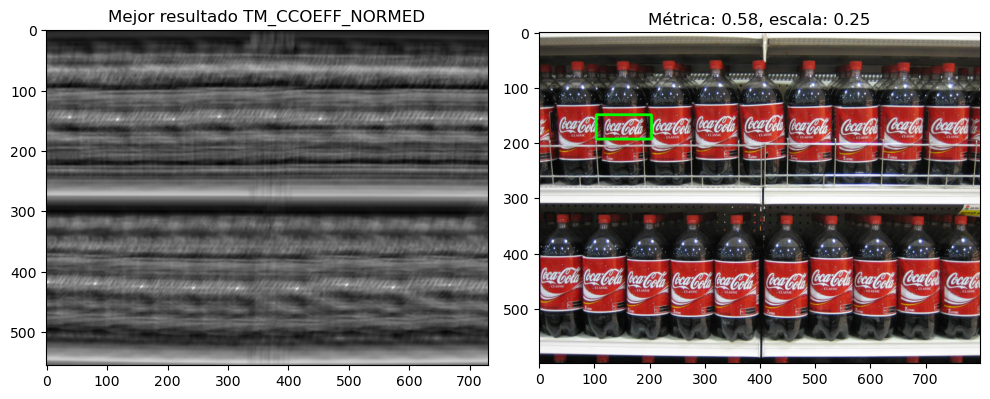

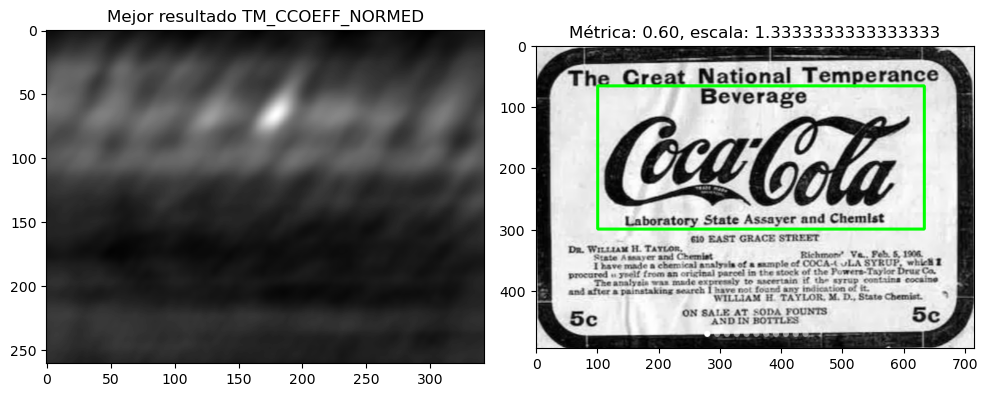

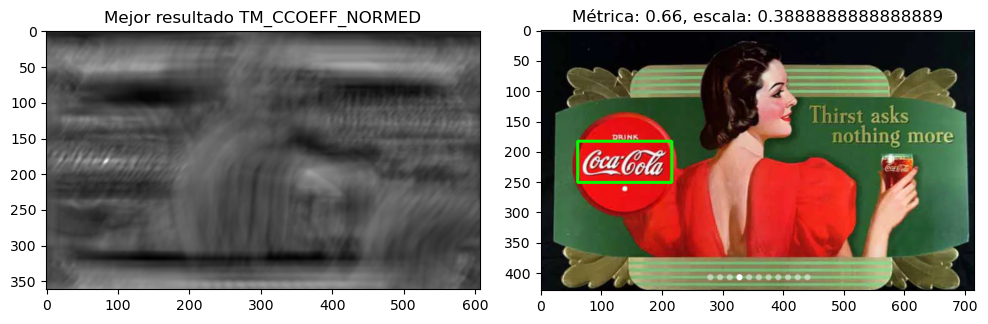

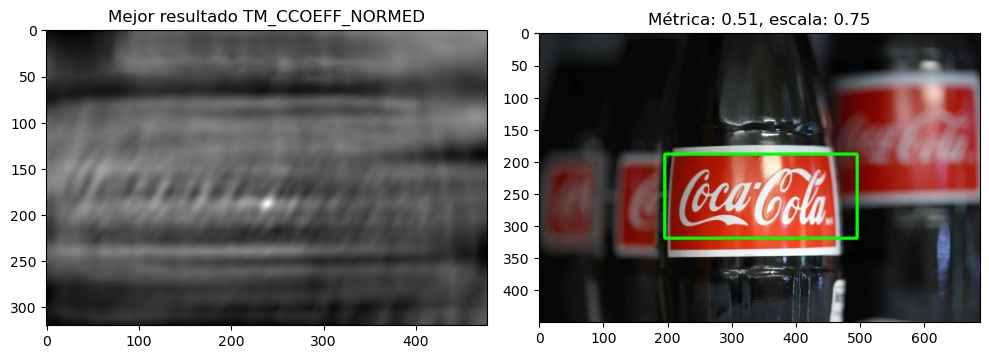

In [13]:
# Se invoca la función con la ruta donde se encuentran las imágenes y el template
match_logo_in_images(image_paths, template_path)

Observar que para el caso de la imagen de la latita (coca_logo_2.png), la bounding box no mantiene la relación de aspecto dado que las dimensiones del template superan el tamaño de la imagen. Esto se debe principalmente a dos motivos:

1. El logo se encuentra curvado en el eje vertical por la forma cilíndrica de la lata, lo cual reduce su ancho con respecto al alto.
2. El template tiene bastante padding (blanco), lo cual hace que la bounding box no encaje de manera justa.

### 2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1

En primer lugar se carga la imagen coca_multi.png.

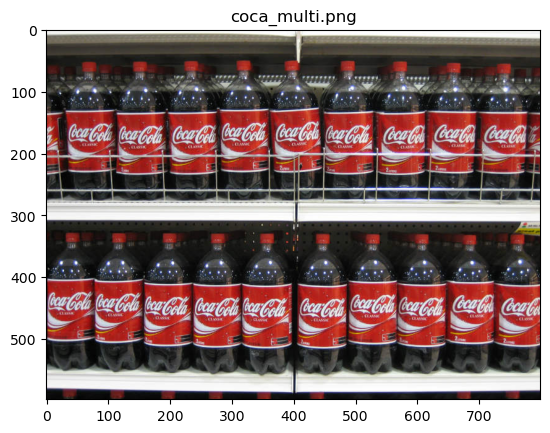

In [14]:
# Se carga la imagen de ejemplo
img = cv.imread('./images/coca_multi.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('coca_multi.png')
plt.show()

Se carga el template y se utiliza una imagen binarizada de letras blancas con fondo negro. En caso de que no den buenos resultados en detecciones múltiples se probarán otras alternativas. El template deberá reducir su tamaño a una escala de 0.25, que fue el valor óptimo obtenido en el ejercicio 1, ya que se puede apreciar que en la imagen todos los logos presentan aproximadamente las mismas dimensiones.

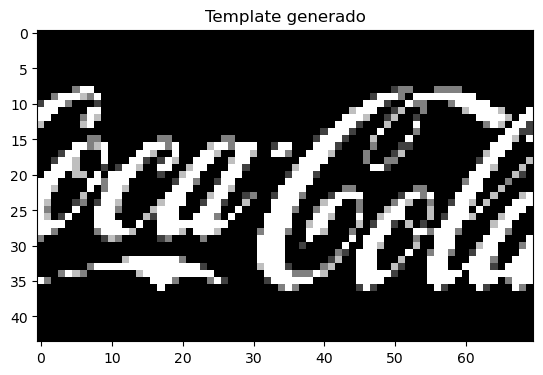

In [15]:
# Se carga el template
template = cv.imread('./template/pattern.png', 0)

# Se realizan los procesamientos que generan otros templates (en este caso dos)
# En este caso se utilizará la versión de letras blancas con fondo negro que es más conveniente.
processed_templates = process_template(template)

# Se cambia el tamaño del template según la escala óptima obtenida en el ejercicio 1 (0.25)
scaled_template = cv.resize(processed_templates[1], None, fx=0.25, fy=0.25)

plt.figure()
plt.imshow(cv.cvtColor(scaled_template, cv.COLOR_BGR2RGB))
plt.title('Template generado')
plt.show()

Para resolver este ejercicio se tomó como base el notebook del práctico realizado en clase, y además se utilizaron los algoritmos Non-Maximum Suppression (NMS) e Intersection over Union (IoU). NMS se utilizó para eliminar detecciones redundantes y evitar así el solapamiento de las bounding boxes.

En términos generales, estos algoritmos trabajan de la siguiente manera:

1. Como entrada se recibe un conjunto de rectángulos correspondientes a cada detección con su correspondiente valor de métrica.
2. Se ordenan estas detecciones de mayor a menor, asumiendo que un valor mayor significa que la detección es mejor. En caso contrario se haría de menor a mayor.
3. Se procesan las detecciones en un ciclo según el orden determinado en el paso 2. Para cada una se calcula IoU contra el resto de las detecciones de forma de descartar aquellas que estén solapadas (según cierto umbral). Estos solapamientos se quitan y no son procesados en el resto del ciclo. En cada iteración se guarda la detección actual en una nueva lista.
4. Terminado el ciclo, se tiene una lista completa de detecciones sin solapamientos (según el umbral definido).

En las celdas siguientes se presentan las funciones que resuelven el problema.

In [16]:
def iou(box1, box2):
    """
    Calcula el IoU (Intersection over Union) entre dos cajas.
    Args:
        box1 (tuple): Tupla con las coordenadas de la caja 1.
        box2 (tuple): Tupla con las coordenadas de la caja 2.
    Returns:
        float: Valor del IoU.
    """
    # Se obtienen las coordenadas de cada caja en variables separadas
    x1, y1, x2, y2 = box1[:4]
    x1b, y1b, x2b, y2b = box2[:4]

    # Se obtienen las coordenadas del rectángulo que correspondería a la intersección
    xi1 = max(x1, x1b)
    yi1 = max(y1, y1b)
    xi2 = min(x2, x2b)
    yi2 = min(y2, y2b)

    # Se calcula el área de la intersección
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Se calcula el área de cada caja
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2b - x1b) * (y2b - y1b)

    # Se calcula el área de la únión de las cajas
    # Se restas inter_area para que no se sume dos veces
    union_area = box1_area + box2_area - inter_area

    # El IoU indica qué porcentaje del área de la unión ocupa la intersección
    return inter_area / union_area

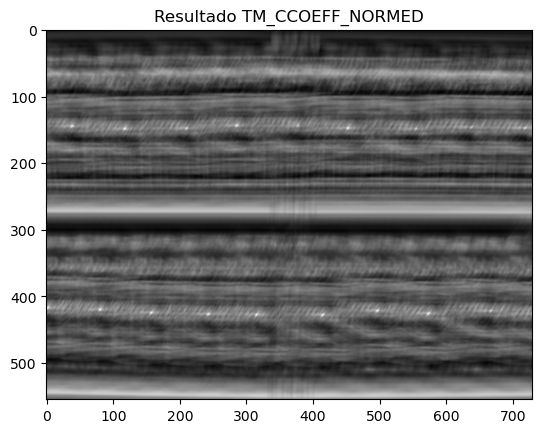

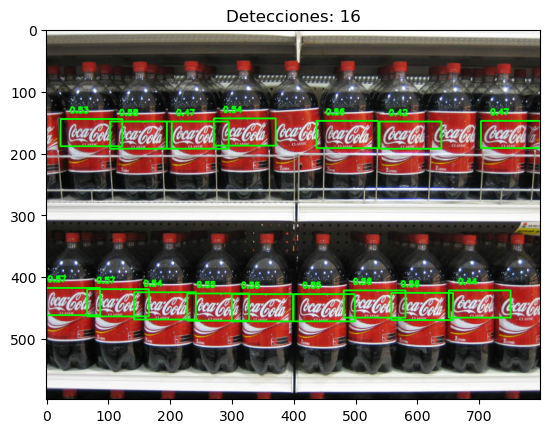

In [17]:

# Se realiza el match entre el template y la imagen
res = cv.matchTemplate(img_gray, scaled_template, cv.TM_CCOEFF_NORMED)

plt.figure()
plt.imshow(res, cmap='gray')
plt.title('Resultado TM_CCOEFF_NORMED')
plt.show()

# Se define un threshold que determina qué tan buena tiene que ser la métrica para ser considerada
threshold = 0.41

# Se obtienen las coordenadas de los puntos que superan el threshold
loc = np.where(res >= threshold)

# Se procesan las detecciones, guardando para cada una el rectángulo que correspondería al template
# y el resultado de la métrica
detections = []
for pt in zip(*loc[::-1]):
    detections.append((pt[0], pt[1], pt[0] + scaled_template.shape[1], pt[1] + scaled_template.shape[0], res[pt[1], pt[0]]))

# Se ordenan las detecciones de mayor a menor por valor de la métrica
detections = sorted(detections, key=lambda x: x[4], reverse=True)

nms_detections = []

# Se utiliza el algoritmo de Non-Maximum Suppression (NMS)
while detections:
    detection_item = detections.pop(0)
    nms_detections.append(detection_item)
    detections = [d for d in detections if not (iou(detection_item, d) > 0.3)]

# Se calcula la relación de aspecto del template original
template_aspect_ratio = template.shape[1] / template.shape[0]
w_full = int(scaled_template.shape[0] * template_aspect_ratio)
w_padding = int((w_full - scaled_template.shape[1]) / 2)

# Se dibujan los rectángulos en la imagen original respetando la relación de aspecto
img_detections = img.copy()
for (x1, y1, x2, y2, metric_val) in nms_detections:
    cv.rectangle(img_detections, (max(0, x1 - w_padding), y1), (min(x2 + w_padding, img.shape[1]), y2), (0, 255, 0), 2)
    # Se muestra el valor de la métrica (sólo el valor para ocupar el menor espacio posible)

    text_size = (y2 - y1) / 100
    cv.putText(img_detections, f'{metric_val:.2f}', (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), 2)

plt.figure()
plt.imshow(cv.cvtColor(img_detections, cv.COLOR_BGR2RGB))
plt.title(f'Detecciones: {len(nms_detections)}')
plt.show()


En las detecciones se pueden detectar solapamientos, los cuales se consideran normales dadas las características del template y de los logos presentes en la imagen. Al igual que en el caso de la lata, aquí también pueden aparecer deformados e incluso con pequeñas rotaciones y movimientos.

Estos solapamientos se podrían evitar tomando una versión más ajustada al tamaño del template, pero se priorizó mostrar el resultado según el patrón original.

### 3. Generalizar el algoritmo del item 2 para todas las imágenes.

La generalización del algoritmo del item 2 implicó fusionarlo con el del item 1. Por lo tanto, se debe realizar el mismo procesamiento de templates y escalados de forma de contemplar la mayoría de los casos. La diferencia es que aquí se almacenan todas las detecciones que superan cierto umbral y luego se aplica NMS utilizando IoU para todos los resultados.

In [18]:
def match_logos(img, processed_templates, template_aspect_ratio, min_scale=0.25, max_scale=3, threshold=0.45):
    """
    Realiza la detección de los logos en la imagen utilizando los templates procesados.

    Args:
        img (numpy.ndarray): Imagen a procesar.
        processed_templates (list): Lista de templates procesados.
        template_aspect_ratio (float): Proporción de aspecto del template.
        min_scale (float, opcional): Valor mínimo de escala para la búsqueda.
        max_scale (float, opcional): Valor máximo de escala para la búsqueda.
        threshold (float, opcional): Valor de umbral para la métrica.
    Returns:
        numpy.ndarray: Imagen con las detecciones realizadas.
        list: Lista de detecciones.
    """

    # Se utiliza la imagen en escala de grises
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    img_h, img_w = img_gray.shape

    scales = np.linspace(min_scale, max_scale, 100)

    all_detections = []

    for scale in scales:
        for template_item in processed_templates:

          scaled_template = cv.resize(template_item, None, fx=scale, fy=scale)
          scaled_template_h, scaled_template_w = scaled_template.shape

          if scaled_template_h <= img_h and scaled_template_w <= img_w:

              res = cv.matchTemplate(img_gray, scaled_template, cv.TM_CCOEFF_NORMED)

              loc = np.where(res >= threshold)

              # Se procesan las detecciones, guardando para cada una el rectángulo que correspondería al template
              # y el resultado de la métrica
              detections = []
              for pt in zip(*loc[::-1]):
                  detections.append((pt[0], pt[1], pt[0] + scaled_template.shape[1], pt[1] + scaled_template.shape[0], res[pt[1], pt[0]]))

              # Se agregan las detecciones para esta versión del template escalado
              all_detections.extend(detections)

    # Se ordenan las detecciones de mayor a menor por valor de la métrica
    all_detections = sorted(all_detections, key=lambda x: x[4], reverse=True)
    final_detections = []

    # Se utiliza el algoritmo de Non-Maximum Suppression (NMS)
    while all_detections:
        current_detection = all_detections.pop(0)
        final_detections.append(current_detection)
        all_detections = [d for d in all_detections if not (iou(current_detection, d) > 0.3)]

    # Se dibujan los rectángulos en la imagen original
    for (x1, y1, x2, y2, metric_val) in final_detections:
        # Se utiliza la relación de aspecto original del template
        w_full = int((y2 - y1) * template_aspect_ratio )
        w_padding = int((w_full - (x2 - x1)) / 2)
        cv.rectangle(img, (max(0, x1 - w_padding), y1), (min(x2 + w_padding, img.shape[1]), y2), (0, 255, 0), 2)

        # Se muestra el valor de la métrica (sólo el valor para ocupar el menor espacio posible)
        text_size = (y2 - y1) / 100
        cv.putText(img, f'{metric_val:.2f}', (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), 2)

    return img, final_detections

In [19]:
def match_logos_images(image_paths, template):
    """
    Realiza la detección múltiple de los logos en las imágenes dadas.

    Args:
        image_paths (list): Lista de rutas a las imágenes que contienen los logos a detectar.
        template (numpy.ndarray): Imagen del template.
    """
    # Se procesa el template
    processed_templates = process_template(template)

    # Se calcula la relación de aspecto para dibujar las bounding boxes en el tamaño adecuado
    template_aspect_ratio = template.shape[1] / template.shape[0]

    for image_path in image_paths:
        img = cv.imread(image_path)
        detected_img, detections = match_logos(img, processed_templates, template_aspect_ratio)

        plt.figure()
        plt.imshow(cv.cvtColor(detected_img, cv.COLOR_BGR2RGB))
        if detections:
            plt.title(f'Detecciones: {len(detections)}')
        else:
            plt.title('No se detectó el logotipo')
        plt.show()

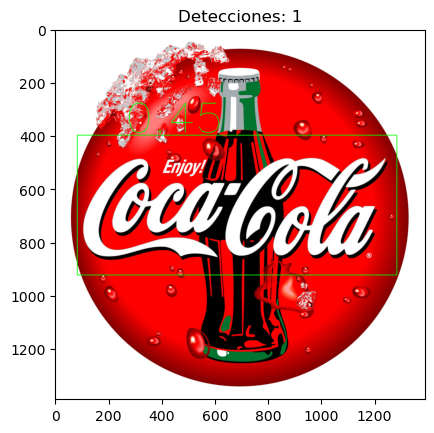

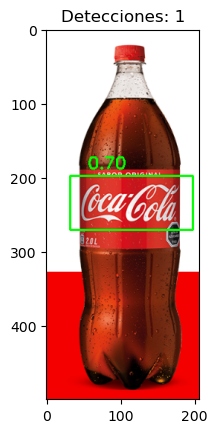

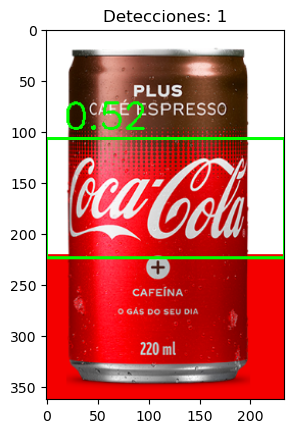

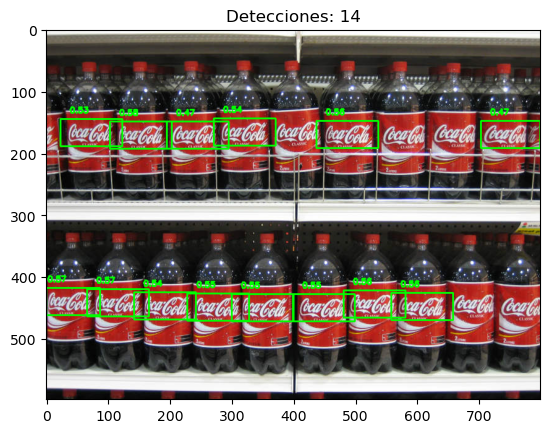

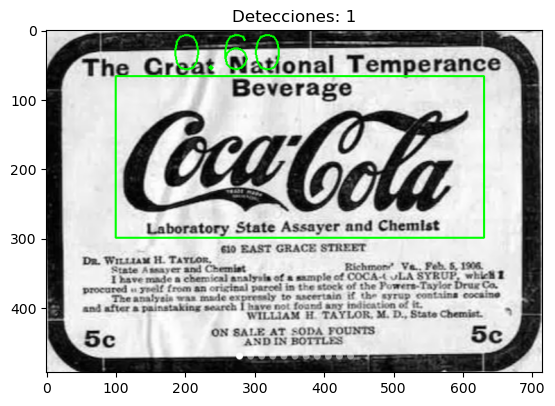

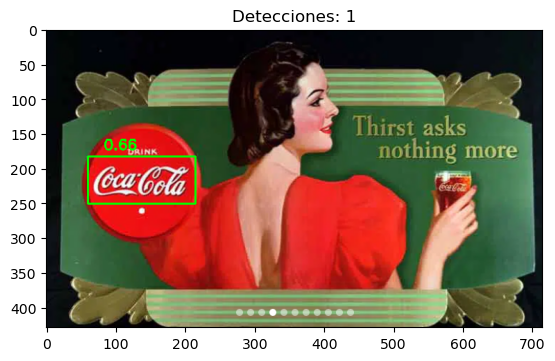

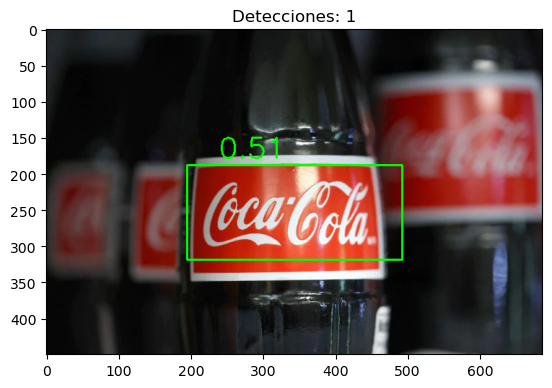

In [21]:
# Se ejecuta el algoritmo genérico para detección de múltiples imágenes
match_logos_images(image_paths, template)